In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
data_dir = "/Users/brucerowan/Documents/capstone/DigitalDemocracyCapstone/data/training/"
target_col = 'transition_value'

In [3]:
training_output_filename = data_dir  + "training_utterances_binary.csv"


In [29]:
# split dataset evenly based on labels
def split_test_train(total, stratify_col):
    transition_rows = total[total[stratify_col] != 0]
    non_transition_rows = total[total[stratify_col] == 0]
    
    # first split transitions into training/testing
    X_train1, X_test1, y_train1, y_test1 = train_test_split(transition_rows, 
                                                    transition_rows[target_col], 
                                                    test_size=0.30, random_state=42)
    
    # assert there are only transition labels in this dataframe
    assert len(X_train1[X_train1[target_col] == 0]) == 0
    assert len(X_test1[X_test1[target_col] == 0]) == 0
    
    train_len = len(X_train1) # number of non-transitions to add to training set
    test_len = len(X_test1) # number of non-transitions to add to testing set
    print(train_len)
    
    # next split non-transitions into training/testing
    X_train2, X_test2, y_train2, y_test2 = train_test_split(non_transition_rows, 
                                                    non_transition_rows[target_col], 
                                                    test_size=0.30, random_state=42)
    
    # pick train_len random rows from non-transition training set
    ###change n = train_len
   
    X_train2 = X_train2.sample(n = train_len*1, axis=0)
    
    # pick test_len random rows from non_transitions testing set
    X_test2 = X_test2.sample(n = test_len, axis=0)
    
    # assert there are no transition utterances in non-transition training and testing set
    assert len(X_train2[X_train2[target_col] != 0]) == 0
    assert len(X_test2[X_test2[target_col] != 0]) == 0
    
    # final result, concat the dataframe
    X_train_final = pd.concat([X_train1, X_train2])
    X_test_final = pd.concat([X_test1, X_test2])
    return X_train_final['text'], X_test_final['text'], X_train_final[target_col], X_test_final[target_col]
    

In [30]:
data = pd.read_table(training_output_filename, sep = "~")
pd.set_option('display.max_colwidth', -1)
data[data[target_col] == 1]['text']


20        to start at the top of the file colleagues which is file item eighty eight.                                                            
93        File item one hundred.                                                                                                                 
203       Thank you madame president colleagues this bill deals with                                                                             
258       Members were coming down to the bitter end so-if you could follow along                                                                
307       ...to return to file item number eighty                                                                                                
308       nine senate bill three one three please read.                                                                                          
436       Today, I present AB 15, the End of Life Option Act.                                                               

In [31]:
#cleaned csv 2869


In [32]:
train = pd.read_table(training_output_filename, sep="~")[['text', target_col]]

In [33]:
#data = pd.read_table("training_utterances_n_range.csv",sep ='~')
#data.head()

In [34]:
#make all 2's into 1's
train.loc[train[target_col] > 0, target_col] = 1
train.columns

Index(['text', 'transition_value'], dtype='object')

In [35]:
x_train, x_test, y_train, y_test = split_test_train(train, target_col)

2008


In [36]:
len(x_train)

4016

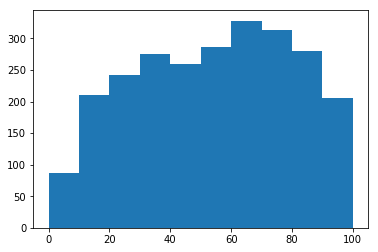

In [37]:
df = train.loc[train[target_col]==1]
lens = (df['text'].apply(len))
plt.hist(lens, range = (0,100))
plt.show()

In [38]:
# there are 5226 transition phrases and 5226*6 = 31356 non transition phrases
# 36582 total

In [39]:
transition_rows = train[train[target_col] != 0]
len(transition_rows)

2869

### Assert training and testing splits are the correct dimensions
### After splitting, training and testing sets should each have 50% transitions and 50% non-transitions
### training dimensions should be 2 * 70% of the number of transitions in the data set
### testing dimensions should be 2 * 30% of the number of transitions in the data set

In [40]:
len(train)

656444

In [41]:
assert len(x_train) == len(y_train)

In [42]:
assert len(x_test) == len(y_test)

In [43]:
assert len(x_train) == int(len(transition_rows) * 0.7) * 2

In [44]:
assert len(x_test) == (len(transition_rows) * 2) - (int(len(transition_rows) * 0.7) * 2)

In [45]:
assert len(y_train[y_train == 0]) == len(y_train[y_train != 0])

In [46]:
assert len(y_test[y_test == 0]) == len(y_test[y_test != 0])

### Vectorize utterances with bag of words features

In [47]:
count_vect = CountVectorizer()
count_vect.fit(np.hstack((x_train, x_test)))
X_train_counts = count_vect.transform(x_train)
X_test_counts = count_vect.transform(x_test)

In [48]:
assert X_train_counts.shape[1] == X_test_counts.shape[1]

### Pass vectorized utterances into a Naive Bayes model

In [49]:
clf = MultinomialNB()
clf.fit(X_train_counts, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Output accuracy on testing set

In [50]:
assert X_test_counts.shape[0] == y_test.shape[0]

In [51]:
clf.score(X_test_counts, y_test, sample_weight=None)

0.57491289198606277

In [52]:
nb_predictions =clf.predict(X_test_counts)
nb_predictions

array([0, 1, 1, ..., 0, 0, 0])

In [53]:
wrong = 0
missed_transition = 0
for i in range(len(nb_predictions)):
    if nb_predictions[i] != y_test.iloc[i]:
        wrong= wrong+1
        print(nb_predictions[i],y_test.iloc[i],x_test.iloc[i])
        if nb_predictions[i] == 0:
            missed_transition = missed_transition +1 

0 1 I'm acquire I'm in does the time it's all.
0 1 Thank you, sir chairman.
0 1 That's the goal, that's what this bill seeks to achieve.
0 1 And we just wanna make sure there's open and transparent conversation in the sighting of future schools.
0 1 Somebody was trying to create a horrible bill.
0 1 Item number 25, AB 2519, motion is do pass.
0 1 We would also take additional steps is needed going forward but the severity of the drought
0 1 Aye. >> Aye, Morrell.
0 1 I think most of us know in our communities, nothing is more precious than naming, because naming really gives permanence and recognition of what we believe in.
0 1 Great, thank you Madam President and members.
0 1 So it was pulled out.
0 1 also hopes to leverage money that people are already receiving.
0 1 Of the 1,396 hits reported in the data, more than 1,000 are for property crimes.
0 1 Close the roll, tally the vote, aye's 70, no's 0.
0 1 And for that reason I'm very appreciative of the bill or the resolution, enter an 

0 1 Because obviously, they needed to vent the gas in order to best deal with it,
0 1 Particularly, not just statewide voting, but basically creating these different classes of voting and
0 1 see what's the manufacturer's recommendation for intervals and use that instead.
0 1 to enter a written transfer agreement with a nearby hospital as a condition of licensure.
0 1 here I would like to say in response to the observation about surely choose
0 1 Aye.
0 1 Aye. >> Wolk, aye.
0 1 I certainly appreciate the effort to account for
0 1 they expanded their cap from 1,000 to 1,500, and even extended the program for a longer period of time til the end of 2016.
0 1 Again this will add local consensus, which weve lacked for so many years, but this is still a work in progress.
0 1 lead the farm worker movement that sparked massive social change in the 1960s and 70s.
0 1 I think it's important for listeners, for the woman who suffered such
0 1 How about 140 to 200 trillion in off book liability, ri

1 0 I will now ask my colleague senator mining to talk about the amendments that were taken
1 0 At its core, this is a bill of inclusion.
1 0 Call the absent members one more time please.
1 0 Last question mr speaker if you and I
1 0 We think that gets to the best interest of the child, we think that gets to making sure that all relatives are considered,
1 0 Congratulations in hopefully creating more housing in San Francisco.
1 0 in our own technology in our agricultural industry
1 0 as a nation california is a world economy and you can say
1 0 Any others wishing to speak against?
1 0 Okay.
1 0 This kind of a provision gives them a little bit of an opening for that.
1 0 she had to find other alternatives for childcare because she couldn't afford anything else.
1 0 That's all right, we'll work on that.
1 0 The vote is 7-0 and
1 0 Comments or questions from Committee?
1 0 From the Medical Association's perspective,
1 0 But I look forward to see it more in the budget for adult education a

In [54]:
print(wrong)
print(missed_transition/wrong)

732
0.5027322404371585


## keras

In [55]:
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.
/Applications/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## tokenize words

In [69]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train, lower = True)

TypeError: texts_to_sequences() got an unexpected keyword argument 'lower'

In [57]:
#so all utterences are same length
padded = pad_sequences(sequences, maxlen = 44)
print(padded.shape)

(4016, 44)


In [58]:
pred = to_categorical(y_train)
pred


array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [59]:
model = Sequential()
model.add(Embedding(20000, 150, input_length=44))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(25,activation = 'sigmoid'))
model.add(Dense(2, activation='sigmoid')) #fully connected layer
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



In [60]:
#class weights 
class_weight = {
    0 : 1.,
    1: 1.,
    }

In [61]:
model.fit(padded, pred,validation_split=0.1, epochs = 1,class_weight = class_weight)


Train on 3614 samples, validate on 402 samples
Epoch 1/1
3614/3614 [==============================] - 16s 4ms/step - loss: 0.6854 - acc: 0.5683 - val_loss: 0.9082 - val_acc: 0.2562


## testing 


In [63]:
tokenizer.fit_on_texts(x_test)
sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(sequences, maxlen = 44)
print(test_padded.shape)

(1722, 44)


In [64]:
predictions = model.predict(test_padded)
predictions = np.argmax(predictions, axis =1)
print(len(predictions))

1722


In [65]:
accuracy_score(predictions,y_test)


0.56329849012775846

In [66]:
#print(x_test.head(100))


In [67]:
wrong = 0
missed_transition = 0
for i in range(len(predictions)):
    if predictions[i] != y_test.iloc[i]:
        wrong= wrong+1
        print(predictions[i],y_test.iloc[i],x_test.iloc[i])
        if predictions[i] == 0:
            missed_transition = missed_transition +1 

0 1 Okay.
0 1 Aye. >> Aye, Morrell.
0 1 Jackson?
0 1 community.
0 1 Aye, Anderson?
0 1 senate.
0 1 Very well.
0 1 Aye. >> Ay, Beall? >> Aye.
0 1 Secretary, please read.
0 1 Lara?
0 1 Here. >> Nguyen here.
0 1 [UNKNOWN]
0 1 Okay, members.
0 1 It's just that simple.
0 1 Here. >> Hernandez here.
0 1 Eggman.
0 1 Aye, Wolk?
0 1 announcements related
0 1 Gaines aye. Galgiani?
0 1 Senator Gaines.
0 1 Williams would madame speaker.
0 1 No.
0 1 Measure passes.
0 1 That's AB 1017.
0 1 Measure passes.
0 1 Jackson? Aye.
0 1 Thank you.
0 1 [UNKNOWN]
0 1 No, bell.
0 1 Aye, Nguyen?
0 1 Aye. >> Aye. Galgiani.
0 1 Senator Wieckowski.
0 1 Hernandez?
0 1 Aye. Opposed say nay.
0 1 ...by glaser by hall.
0 1 take
0 1 Thank you.
0 1 No. >> No, Bates?
0 1 Stone? >> Aye.
0 1 Nelson?
0 1 Jones.
0 1 Thank you.
0 1 Good morning everyone.
0 1 Senator De Leon.
0 1 Aye Roth?
0 1 Any support?
0 1 Wieckowski here.
0 1 I'm so sorry.
0 1 Senator Huff.
0 1 Aye, McGuire.
0 1 Secretary please read.
0 1 File item.
0 1 Aye M

1 0 President Regan personally congratulated Crane on his distinguished Eagle Scout award and was once lassoed by Crane in one of their meetings.
1 0 Thank you Mr President, colleagues this bill will bring transparency, always good thing to the Kell Ocean's Standard Board
1 0 About 2.4 billion proposed for the California Highway Patrol,
1 0 efficiently removed by pressing a bullet into a button is in fact detachable by the plain meaning of the word.
1 0 I had a bill, we talked about it earlier, one of the speakers said, we need to stop the demand.
1 0 where he met his bride and wife of 65 years, Beatrice.
1 0 So I think that a lot of people think that
1 0 San Bernardino area office replacements.
1 0 ...two thousand sixteen and consent for the senate to do the same.
1 0 how the success of the team is really reflective of the great success of the university and President Hirshman is here.
1 0 put in the budget?
1 0 I think it makes a lot of sense, I mean especially in our current interes

In [68]:
print(wrong)
print(missed_transition)
print(missed_transition/wrong)


752
120
0.1595744680851064


## Notes
3 epochs seems to be the sweet spot

(using 6 times more non transitions)

model 1: 1 epochs, adam optimzer, class weights(0:1,1:6)
accuracy score: 58.06%, (61% guessed 0 when correct was 1)

model 1: 4 epochs, adam optimzer, class weights(0:1,1:6)
accuracy score: 53.46%, (72% guessed 0 when correct was 1)

model 1: 10 epochs, adam optimzer, class weights (0:1,1:6)
accuracy score: 53.31%, (61% guessed 0 when correct was 1)

model 1: 15 epochs, adam optimzer, class weights (0:1,1:6)
accuracy score: 53.15%, (71% guessed 0 when correct was 1)

model 1: 20 epochs, adam optimzer, class weights (0:1,1:6)
accuracy score: 51.36%, (69% guessed 0 when correct was 1)

model 1: 25 epochs, adam optimzer, class weights (0:1,1:6)
accuracy score: 52.83%, (67% guessed 0 when correct was 1)

model 1: 30 epochs, adam optimzer, class weights (0:1,1:6)
accuracy score: 51.65%, (73% guessed 0 when correct was 1)

model 1: 1 epochs, rmsprop, class weights (0:1,1:6)
accuracy score: 45.5%, (74% guessed 0 when correct was 1)

###model 2 

1 epoch, adam
accuracy score: 51.4%, (67.8% guessed 0 when correct was 1)

4 epochs, adam
accuracy score: 52.0%, (71.8% guessed 0 when correct was 1


### model1 
model = Sequential()
model.add(Embedding(20000, 150, input_length=44))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(2, activation='sigmoid')) #fully connected layer
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


### model2 (remove conv layer and pooling layer)
model = Sequential()
model.add(Embedding(20000, 150, input_length=44))

model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(2, activation='sigmoid')) #fully connected layer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



## model 3(model 1 with another dense layer) 59% acc on n_range data
model = Sequential()
model.add(Embedding(20000, 150, input_length=44))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(25,activation = 'sigmoid'))
model.add(Dense(2, activation='sigmoid')) #fully connected layer
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
